# Load Dependencies

In [ ]:
!pip install shap

In [ ]:
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Data generation

In [ ]:
orig_url = "https://drive.google.com/file/d/15H8TTe7mZQV4QYiV545k7_WjNcO5_lT-/view"
file_id = orig_url.split('/')[-2]
data_path='https://drive.google.com/uc?export=download&id=' + file_id

In [ ]:
data = pd.read_csv(data_path, delimiter=",")
print(data.shape)
data.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [ ]:
data = data.drop(["id", "Unnamed: 32"], 1)

y = data["diagnosis"].replace(["B", "M"], [0, 1])
X = data.drop("diagnosis", 1)
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=data["diagnosis"], random_state=50
)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 398 samples.
Testing set has 171 samples.


# Interpreting Classification Models

We will look at how to interpret a variety of classification models here:

- Logistic Regression
- XGBoost Classifier

## Interpreting Logistic Regression Model


### Train and Evaluate Model Performance

In [ ]:
from sklearn.linear_model import LogisticRegression

lor = LogisticRegression(solver='liblinear')

lor.fit(X_train, y_train)

pred_lor = lor.predict(X_test)

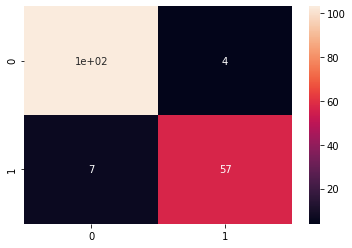

In [ ]:
cf = confusion_matrix(y_test, pred_lor)
sns.heatmap(cf, annot=True);

In [ ]:
print(classification_report(y_test, pred_lor))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       107
           1       0.93      0.89      0.91        64

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



### Create SHAP Explainer & Compute SHAP values

In [ ]:
explainer = shap.KernelExplainer(lor.predict, data=X_train)
shap_values = explainer.shap_values(X_test)

Using 398 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


### View SHAP values

In [ ]:
X_test.head(3)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
292,12.95,16.02,83.14,513.7,0.10050,0.07943,0.06155,0.03370,0.1730,0.06470,0.2094,0.7636,1.2310,17.670,0.008725,0.02003,0.02335,0.01132,0.02625,0.004726,13.74,19.93,88.81,585.4,0.14830,0.2068,0.2241,0.10560,0.3380,0.09584
547,10.26,16.58,65.85,320.8,0.08877,0.08066,0.04358,0.02438,0.1669,0.06714,0.1144,1.0230,0.9887,7.326,0.010270,0.03084,0.02613,0.01097,0.02277,0.005890,10.83,22.04,71.08,357.4,0.14610,0.2246,0.1783,0.08333,0.2691,0.09479
402,12.96,18.29,84.18,525.2,0.07351,0.07899,0.04057,0.01883,0.1874,0.05899,0.2357,1.2990,2.3970,20.210,0.003629,0.03713,0.03452,0.01065,0.02632,0.003705,14.13,24.61,96.31,621.9,0.09329,0.2318,0.1604,0.06608,0.3207,0.07247


In [ ]:
pd.DataFrame(shap_values, columns=X_test.columns).head(3)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.044602,0.016920,0.037297,-0.068398,0.000000,-0.005666,0.0,0.0,0.0,0.0,0.0,0.011601,0.014802,-0.082214,0.0,0.0,0.0,0.0,0.000000,0.000000,0.069809,-0.061006,-0.194603,-0.143961,0.0,-0.006018,0.000000,0.000000,0.00000,0.0
1,0.151515,0.000000,0.127911,-0.132771,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.101542,0.0,0.0,0.0,0.0,0.000000,0.000000,0.159964,-0.031008,-0.315077,-0.217156,0.0,-0.008669,0.000000,0.000000,0.00000,0.0
2,0.028510,0.012303,0.021777,-0.063371,-0.004777,-0.007938,0.0,0.0,0.0,0.0,0.0,0.007968,0.011531,-0.090636,0.0,0.0,0.0,0.0,0.007886,-0.006227,0.055457,-0.037544,-0.128778,-0.148171,0.0,-0.003052,-0.008733,-0.007308,-0.00573,0.0


### Global Interpretation - Feature Importance Globally

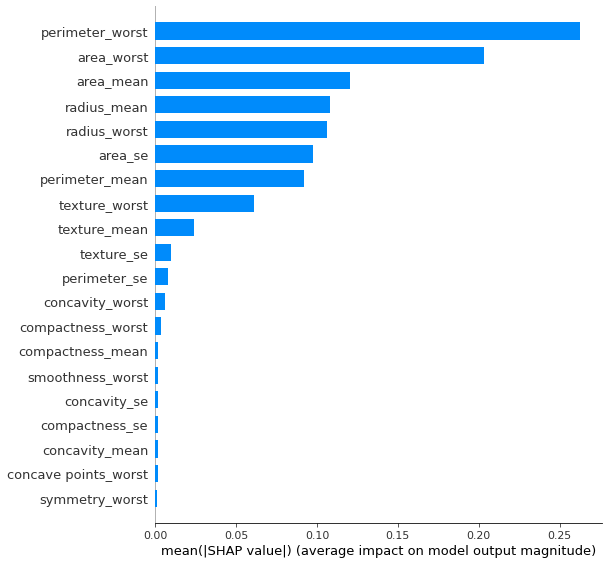

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

### Local Interpretations

In [ ]:
explainer.expected_value

0.3668341708542714

In [ ]:
y_test.iloc[10], pred_lor[10]

(1, 1)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[10, :], X_test.iloc[10, :])

In [ ]:
y_test.iloc[1], pred_lor[1]

(0, 0)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1, :], X_test.iloc[1, :])

### Partial Dependence Plots

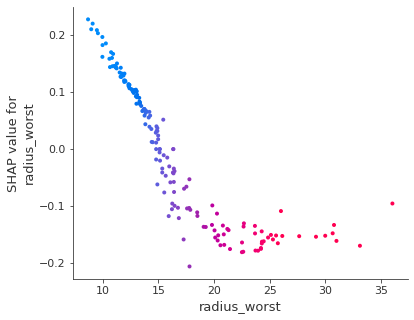

In [ ]:
shap.dependence_plot(ind='radius_worst', interaction_index='radius_worst',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

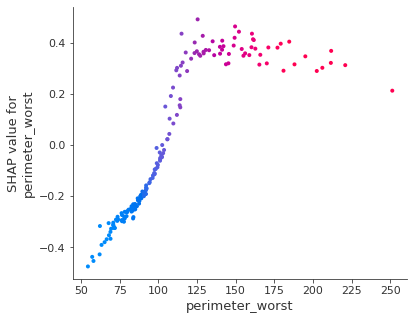

In [ ]:
shap.dependence_plot(ind='perimeter_worst', interaction_index='perimeter_worst',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

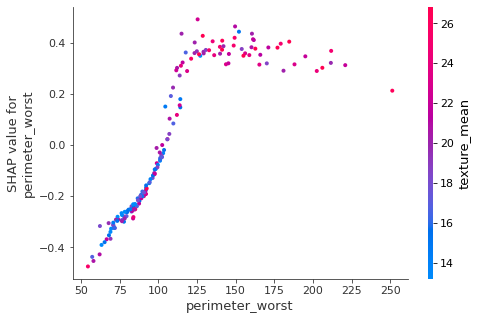

In [ ]:
shap.dependence_plot(ind='perimeter_worst', interaction_index='texture_mean',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

## Interpreting XGBoost Classifier Model


### Train and Evaluate Model Performance

In [ ]:
from xgboost import XGBClassifier


xgb = XGBClassifier()
xgb.fit(X_train, y_train)

pred_xgb = xgb.predict(X_test)

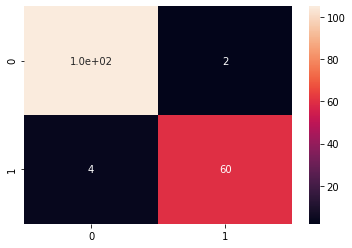

In [ ]:
cf = confusion_matrix(y_test, pred_xgb)
sns.heatmap(cf, annot=True);

In [ ]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       107
           1       0.97      0.94      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



### Create SHAP Explainer & Compute SHAP values

In [ ]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

### View SHAP values

In [ ]:
X_test.head(3)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
292,12.95,16.02,83.14,513.7,0.10050,0.07943,0.06155,0.03370,0.1730,0.06470,0.2094,0.7636,1.2310,17.670,0.008725,0.02003,0.02335,0.01132,0.02625,0.004726,13.74,19.93,88.81,585.4,0.14830,0.2068,0.2241,0.10560,0.3380,0.09584
547,10.26,16.58,65.85,320.8,0.08877,0.08066,0.04358,0.02438,0.1669,0.06714,0.1144,1.0230,0.9887,7.326,0.010270,0.03084,0.02613,0.01097,0.02277,0.005890,10.83,22.04,71.08,357.4,0.14610,0.2246,0.1783,0.08333,0.2691,0.09479
402,12.96,18.29,84.18,525.2,0.07351,0.07899,0.04057,0.01883,0.1874,0.05899,0.2357,1.2990,2.3970,20.210,0.003629,0.03713,0.03452,0.01065,0.02632,0.003705,14.13,24.61,96.31,621.9,0.09329,0.2318,0.1604,0.06608,0.3207,0.07247


In [ ]:
pd.DataFrame(shap_values, columns=X_test.columns).head(3)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-0.041297,-0.055981,0.0,-0.037426,0.033306,-0.017832,-0.073304,-0.700368,-0.086037,-0.00416,-0.038795,0.011837,-0.005177,-0.996486,0.0,-0.045209,-0.013269,-0.019630,-0.146918,-0.073876,-0.105646,-1.097132,-0.774972,-0.914962,0.148955,-0.027535,0.133923,-0.842675,0.121207,-0.057953
1,-0.047014,-0.055981,0.0,-0.037426,-0.122043,-0.017832,-0.095917,-0.784973,-0.091642,-0.00416,-0.038795,0.006879,-0.005177,-0.921534,0.0,-0.077490,-0.013269,-0.019630,-0.155863,-0.055241,-0.095298,-0.559219,-0.874349,-0.963661,0.145855,-0.027535,-0.358896,-0.834588,-0.097533,-0.057953
2,-0.047014,-0.055981,0.0,-0.045225,-0.196294,-0.017832,-0.102623,-0.864232,-0.128912,-0.00416,-0.043249,-0.005133,-0.005177,-0.866504,0.0,-0.077490,-0.013269,-0.026543,-0.155863,-0.031419,-0.095298,-0.169634,-0.819144,-0.808675,-0.132311,-0.018488,-0.352968,-0.879419,-0.052383,-0.094241


### Global Interpretation - Feature Importance Globally

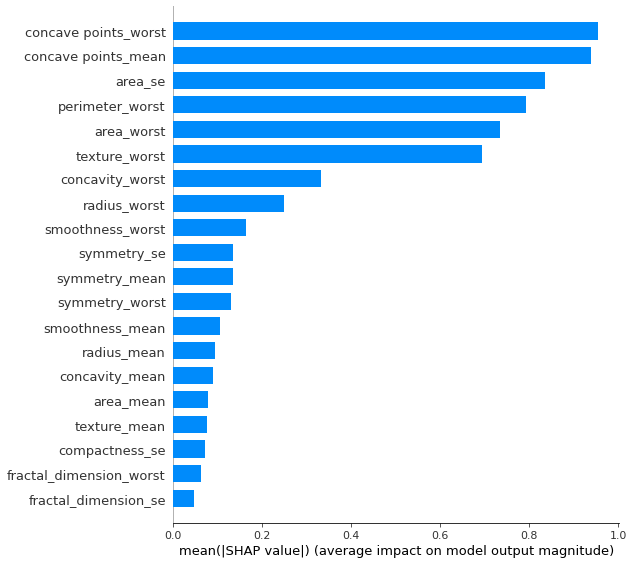

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

### Local Interpretations

In [ ]:
explainer.expected_value

-0.97640926

In [ ]:
y_test.iloc[10], pred_xgb[10]

(1, 0)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[10, :], X_test.iloc[10, :])

In [ ]:
y_test.iloc[1], pred_xgb[1]

(0, 0)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1, :], X_test.iloc[1, :])

### Partial Dependence Plots

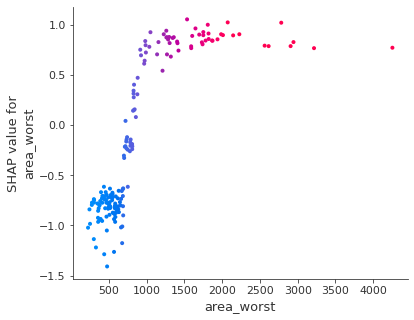

In [ ]:
shap.dependence_plot(ind='area_worst', interaction_index='area_worst',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

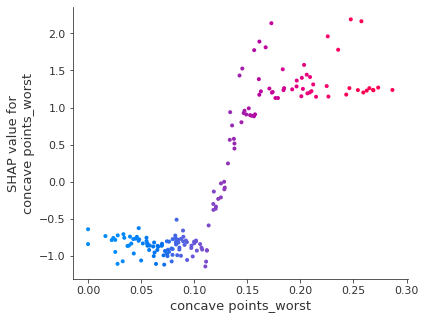

In [ ]:
shap.dependence_plot(ind='concave points_worst', interaction_index='concave points_worst',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

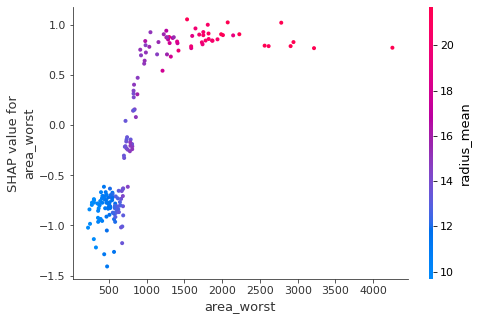

In [ ]:
shap.dependence_plot(ind='area_worst', interaction_index='radius_mean',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

# Bonus

Compare the results of a baseline model to a model trained using chosen features after feature selection from the exercise on Advanced classification models day.

In [ ]:
drop_list1 = [
    "perimeter_mean",
    "area_mean",
    "area_se",
    "perimeter_se",
    "area_worst",
    "perimeter_worst",
    "radius_mean",
    "texture_mean",
    "compactness_mean",
    "concavity_mean",
    "compactness_worst",
    "concavity_worst",
    "concave points_mean",
]

X_train_reduced = X_train.drop(drop_list1, axis=1)
X_test_reduced = X_test.drop(drop_list1, axis=1)


X_train_reduced.head()

,smoothness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
479,0.10260,0.2151,0.06578,0.3147,0.9857,0.009197,0.05470,0.08079,0.022150,0.02773,0.006355,17.39,23.05,0.1377,0.17750,0.3318,0.09136
98,0.08983,0.1620,0.06582,0.2315,0.5391,0.006153,0.01330,0.01693,0.006884,0.01651,0.002551,13.06,17.16,0.1431,0.08449,0.2772,0.08756
281,0.07813,0.2101,0.06113,0.5619,1.2680,0.008034,0.01442,0.01514,0.018460,0.02921,0.002005,13.31,18.26,0.1036,0.08290,0.3101,0.06688
81,0.10780,0.1942,0.06902,0.2860,1.0160,0.006794,0.03575,0.03980,0.013830,0.02134,0.004603,15.53,23.19,0.1536,0.17080,0.3527,0.10160
566,0.08455,0.1590,0.05648,0.4564,1.0750,0.005903,0.03731,0.04730,0.015570,0.01318,0.003892,18.98,34.12,0.1139,0.14180,0.2218,0.07820


In [ ]:
from sklearn.linear_model import LogisticRegression

lor = LogisticRegression(solver='liblinear')

lor.fit(X_train_reduced, y_train)

pred_lor = lor.predict(X_test_reduced)

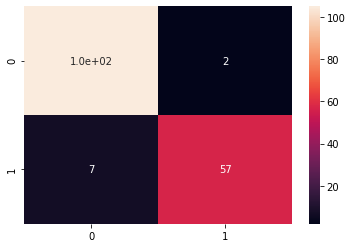

In [ ]:
cf = confusion_matrix(y_test, pred_lor)
sns.heatmap(cf, annot=True);

In [ ]:
print(classification_report(y_test, pred_lor))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       107
           1       0.97      0.89      0.93        64

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171



### Create SHAP Explainer & Compute SHAP values

In [ ]:
explainer = shap.KernelExplainer(lor.predict, data=X_train_reduced)
shap_values = explainer.shap_values(X_test_reduced)

Using 398 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
X_test_reduced.head(3)

,smoothness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
292,0.10050,0.1730,0.06470,0.2094,0.7636,0.008725,0.02003,0.02335,0.01132,0.02625,0.004726,13.74,19.93,0.14830,0.10560,0.3380,0.09584
547,0.08877,0.1669,0.06714,0.1144,1.0230,0.010270,0.03084,0.02613,0.01097,0.02277,0.005890,10.83,22.04,0.14610,0.08333,0.2691,0.09479
402,0.07351,0.1874,0.05899,0.2357,1.2990,0.003629,0.03713,0.03452,0.01065,0.02632,0.003705,14.13,24.61,0.09329,0.06608,0.3207,0.07247


In [ ]:
pd.DataFrame(shap_values, columns=X_test_reduced.columns).head(3)

,smoothness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.0,0.0,0.0,-0.074842,0.038958,0.0,0.0,0.0,0.0,0.0,0.0,-0.220093,-0.051551,0.0,-0.009055,0.0,0.0
1,0.0,0.0,0.0,-0.055552,0.012667,0.0,0.0,0.0,0.0,0.0,0.0,-0.236032,-0.027771,0.0,-0.009895,0.0,0.0
2,0.0,0.0,0.0,-0.068796,-0.006520,0.0,0.0,0.0,0.0,0.0,0.0,-0.210185,-0.014232,0.0,-0.016849,0.0,0.0


### Global Interpretation - Feature Importance Globally

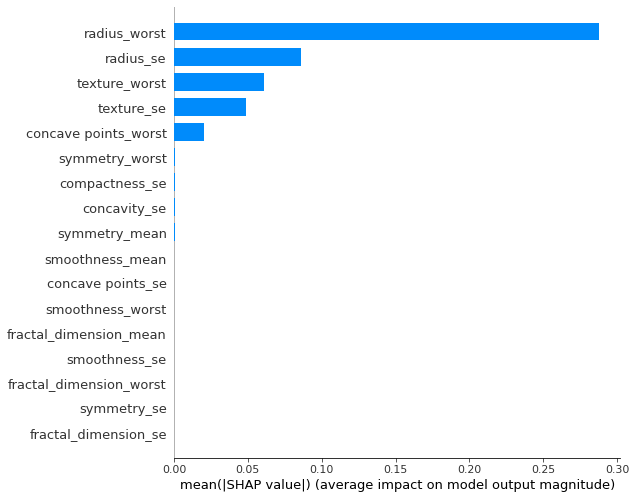

In [ ]:
shap.summary_plot(shap_values, X_test_reduced, plot_type='bar')

### Local Interpretations

In [ ]:
explainer.expected_value

0.31658291457286436

In [ ]:
y_test.iloc[10], pred_lor[10]

(1, 1)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[10, :], X_test_reduced.iloc[10, :])

In [ ]:
y_test.iloc[1], pred_lor[1]

(0, 0)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1, :], X_test_reduced.iloc[1, :])

### Partial Dependence Plots

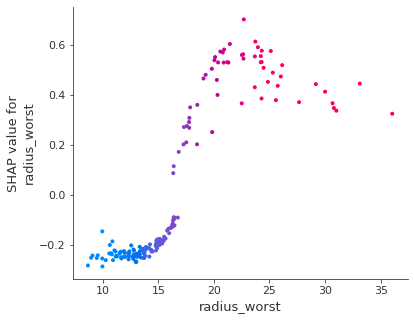

In [ ]:
shap.dependence_plot(ind='radius_worst', interaction_index='radius_worst',
                     shap_values=shap_values, 
                     features=X_test_reduced,  
                     display_features=X_test_reduced)

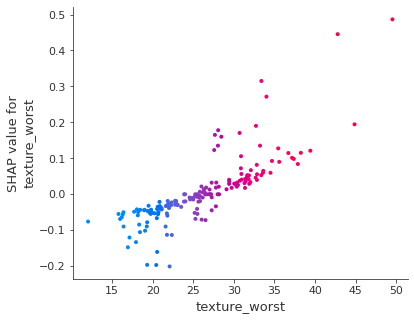

In [ ]:
shap.dependence_plot(ind='texture_worst', interaction_index='texture_worst',
                     shap_values=shap_values, 
                     features=X_test_reduced,  
                     display_features=X_test_reduced)

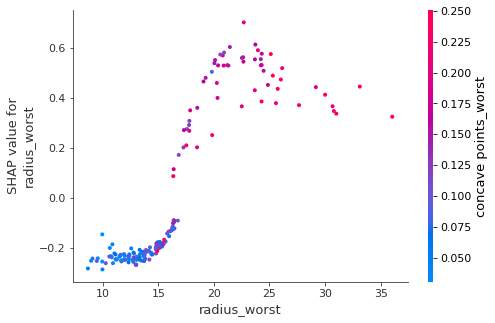

In [ ]:
shap.dependence_plot(ind='radius_worst', interaction_index='concave points_worst',
                     shap_values=shap_values, 
                     features=X_test_reduced,  
                     display_features=X_test_reduced)